In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception, MobileNet, MobileNetV2, DenseNet121, DenseNet169, DenseNet201, NASNetLarge, NASNetMobile
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from tensorflow.keras.preprocessing import image

In [ ]:
# Parámetros
dataset_dir = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\Tarea 6"
batch_size = 32
img_size = (224, 224)  # Ajusta el tamaño deseado
validation_split = 0.2  # 20% de los datos para validación
seed = 123  # Semilla para reproducibilidad

# Carga del dataset para entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",        # Usamos la parte de entrenamiento
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  # O 'int' según tus necesidades
    shuffle=True
)

# Carga del dataset para validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",      # Usamos la parte de validación
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)


# Verificar etiquetas asignadas
class_names = train_ds.class_names  # Debería mostrar ['cats', 'dogs']
print("Clases asignadas:", class_names)

# Verificar tamaños de los datasets
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Entrenamiento: {train_size} batches")
print(f"Validación: {val_size} batches")

Found 24953 files belonging to 2 classes.
Using 19963 files for training.
Found 24953 files belonging to 2 classes.
Using 4990 files for validation.
Clases asignadas: ['Cat', 'Dog']
Entrenamiento: 624 batches
Validación: 156 batches


# MobileNetV2

In [89]:
input_shape = (224, 224, 3)
num_classes = 2

In [90]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

In [91]:
base_model.trainable = False

In [ ]:
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

In [93]:
model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50


624/624 [==============================] - 39s 59ms/step - loss: 0.6207 - accuracy: 0.6618 - val_loss: 0.5278 - val_accuracy: 0.7431
Epoch 2/50
624/624 [==============================] - 36s 57ms/step - loss: 0.5428 - accuracy: 0.7244 - val_loss: 0.5049 - val_accuracy: 0.7509
Epoch 3/50
624/624 [==============================] - 36s 57ms/step - loss: 0.5182 - accuracy: 0.7406 - val_loss: 0.4897 - val_accuracy: 0.7619
Epoch 4/50
624/624 [==============================] - 36s 58ms/step - loss: 0.4988 - accuracy: 0.7506 - val_loss: 0.4852 - val_accuracy: 0.7647
Epoch 5/50
624/624 [==============================] - 35s 57ms/step - loss: 0.4854 - accuracy: 0.7595 - val_loss: 0.4941 - val_accuracy: 0.7613
Epoch 6/50
624/624 [==============================] - 35s 57ms/step - loss: 0.4735 - accuracy: 0.7721 - val_loss: 0.4748 - val_accuracy: 0.7703
Epoch 7/50
624/624 [==============================] - 35s 57ms/step - loss: 0.4619 - accuracy: 0.7780 - val_loss: 0.4866 - val_accuracy: 0.7675
Epo

In [96]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 7s 45ms/step - loss: 0.4651 - accuracy: 0.7792
Accuracy: 0.7791582942008972


In [ ]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.57).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 0s 24ms/step


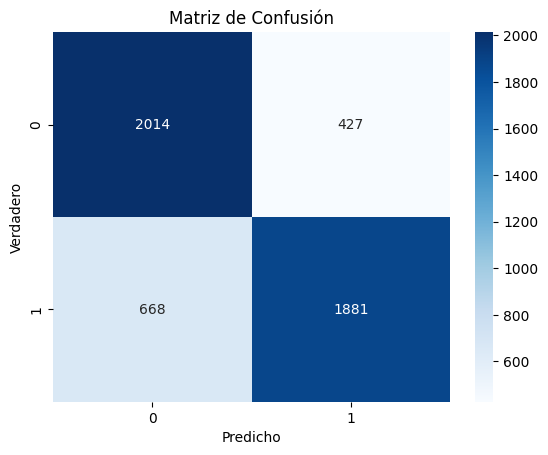

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2441
           1       0.81      0.74      0.77      2549

    accuracy                           0.78      4990
   macro avg       0.78      0.78      0.78      4990
weighted avg       0.78      0.78      0.78      4990



In [122]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

1/1 [==============================] - 0s 24ms/step


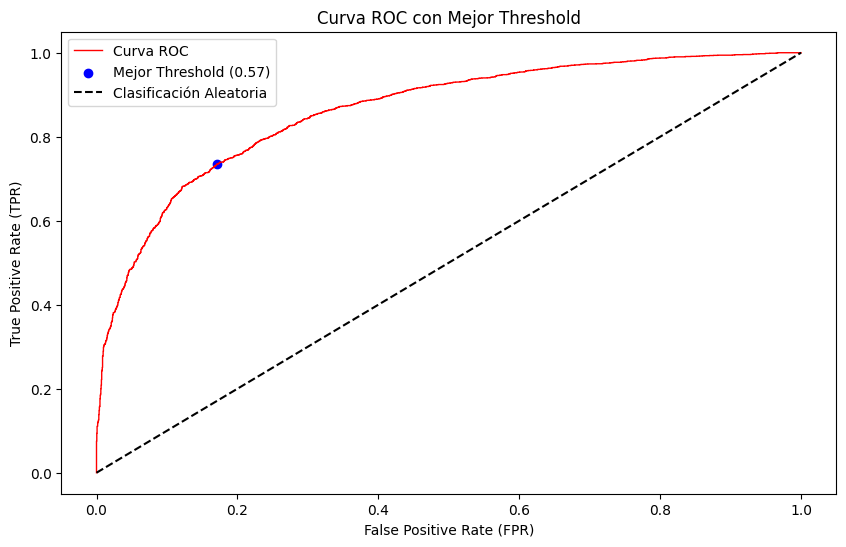

In [ ]:
FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

# VGG16

In [142]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

In [143]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
624/624 [==============================] - 130s 203ms/step - loss: 0.2606 - accuracy: 0.9321 - val_loss: 0.0824 - val_accuracy: 0.9715
Epoch 2/50
624/624 [==============================] - 122s 195ms/step - loss: 0.1308 - accuracy: 0.9592 - val_loss: 0.0630 - val_accuracy: 0.9756
Epoch 3/50
624/624 [==============================] - 124s 198ms/step - loss: 0.0989 - accuracy: 0.9665 - val_loss: 0.0584 - val_accuracy: 0.9774
Epoch 4/50
624/624 [==============================] - 125s 200ms/step - loss: 0.0842 - accuracy: 0.9678 - val_loss: 0.0546 - val_accuracy: 0.9798
Epoch 5/50
624/624 [==============================] - 128s 206ms/step - loss: 0.0675 - accuracy: 0.9757 - val_loss: 0.0558 - val_accuracy: 0.9758
Epoch 6/50
624/624 [==============================] - 127s 204ms/step - loss: 0.0625 - accuracy: 0.9770 - val_loss: 0.0526 - val_accuracy: 0.9778
Epoch 7/50
624/624 [==============================] - 125s 199ms/step - loss: 0.0545 - accuracy: 0.9799 - val_loss: 0.0524 -

1/1 [==============================] - 0s 99ms/step


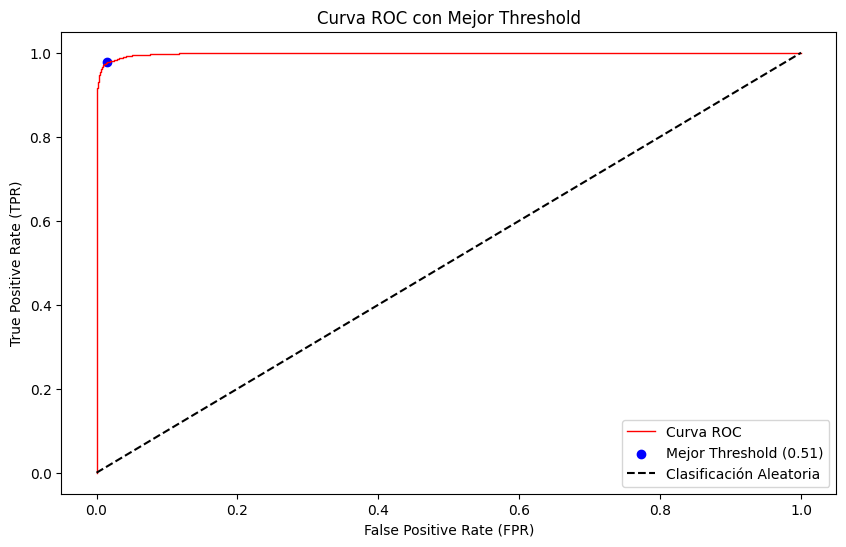

In [144]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

In [145]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 25s 157ms/step - loss: 0.0515 - accuracy: 0.9816
Accuracy: 0.981563150882721


1/1 [==============================] - 0s 102ms/step


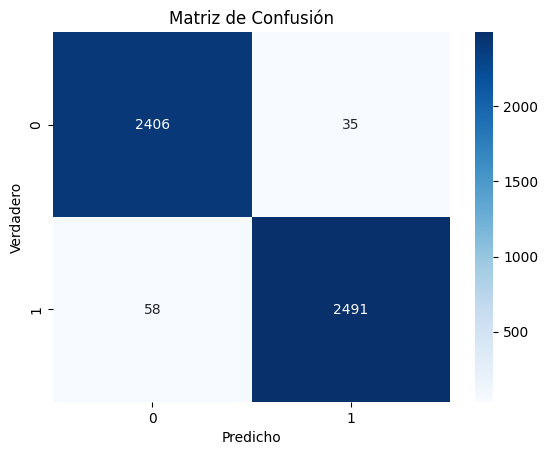

In [196]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.51).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [198]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2441
           1       0.99      0.98      0.98      2549

    accuracy                           0.98      4990
   macro avg       0.98      0.98      0.98      4990
weighted avg       0.98      0.98      0.98      4990



# InceptionV3

In [157]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

87910968/87910968 [==============================] - 8s 0us/step


In [158]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

Epoch 1/20
624/624 [==============================] - 69s 104ms/step - loss: 2.7591 - accuracy: 0.5605 - val_loss: 0.6429 - val_accuracy: 0.6246
Epoch 2/20
624/624 [==============================] - 61s 98ms/step - loss: 0.7053 - accuracy: 0.5831 - val_loss: 0.6520 - val_accuracy: 0.6361
Epoch 3/20
624/624 [==============================] - 61s 98ms/step - loss: 0.6751 - accuracy: 0.5856 - val_loss: 0.6439 - val_accuracy: 0.6421
Epoch 4/20
624/624 [==============================] - 61s 98ms/step - loss: 0.6728 - accuracy: 0.5904 - val_loss: 0.6547 - val_accuracy: 0.6238
Epoch 5/20
624/624 [==============================] - 61s 98ms/step - loss: 0.6727 - accuracy: 0.5806 - val_loss: 0.6517 - val_accuracy: 0.6192
Epoch 6/20
624/624 [==============================] - 61s 98ms/step - loss: 0.6648 - accuracy: 0.5926 - val_loss: 0.6536 - val_accuracy: 0.5926


1/1 [==============================] - 1s 708ms/step


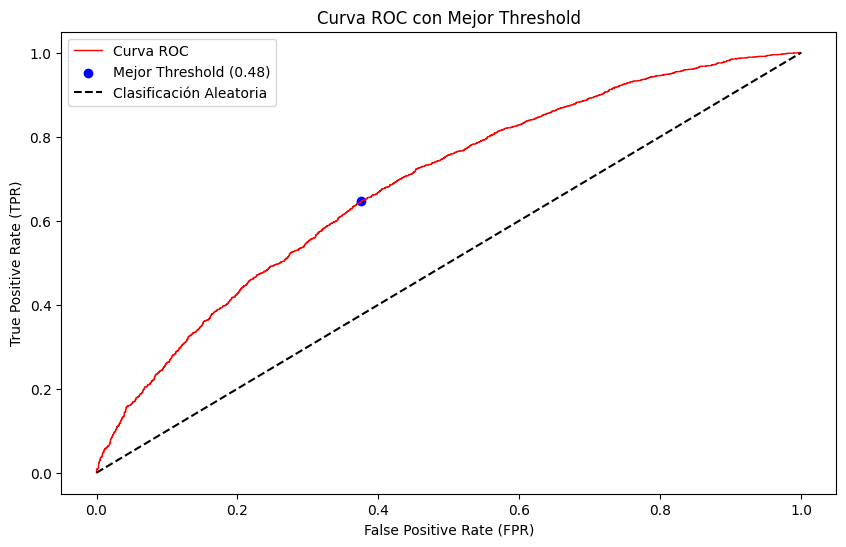

In [159]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

In [160]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 13s 79ms/step - loss: 0.6432 - accuracy: 0.6244
Accuracy: 0.6244488954544067


1/1 [==============================] - 1s 735ms/step


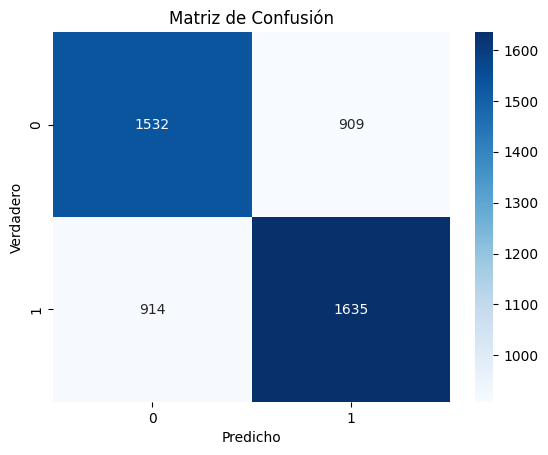

In [200]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.48).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [201]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2441
           1       0.64      0.64      0.64      2549

    accuracy                           0.63      4990
   macro avg       0.63      0.63      0.63      4990
weighted avg       0.63      0.63      0.63      4990



# MobileNetV2 Unfreeze

In [181]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

In [183]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

Epoch 1/20
624/624 [==============================] - 44s 70ms/step - loss: 0.4622 - accuracy: 0.7775 - val_loss: 0.9355 - val_accuracy: 0.5866
Epoch 2/20
624/624 [==============================] - 43s 69ms/step - loss: 0.3020 - accuracy: 0.8670 - val_loss: 0.3785 - val_accuracy: 0.8367
Epoch 3/20
624/624 [==============================] - 42s 67ms/step - loss: 0.2079 - accuracy: 0.9125 - val_loss: 0.4742 - val_accuracy: 0.8174
Epoch 4/20
624/624 [==============================] - 43s 68ms/step - loss: 0.1339 - accuracy: 0.9457 - val_loss: 0.4883 - val_accuracy: 0.8353
Epoch 5/20
624/624 [==============================] - 42s 67ms/step - loss: 0.0921 - accuracy: 0.9629 - val_loss: 0.6317 - val_accuracy: 0.8409
Epoch 6/20
624/624 [==============================] - 42s 67ms/step - loss: 0.0614 - accuracy: 0.9768 - val_loss: 0.8482 - val_accuracy: 0.8321
Epoch 7/20
624/624 [==============================] - 42s 68ms/step - loss: 0.0556 - accuracy: 0.9808 - val_loss: 1.3589 - val_accuracy:

1/1 [==============================] - 0s 457ms/step


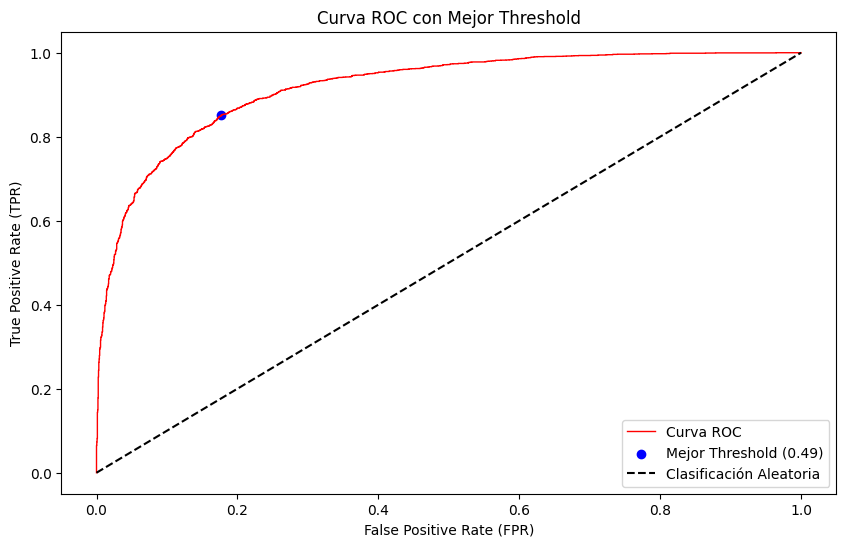

In [184]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

In [185]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 8s 46ms/step - loss: 0.3785 - accuracy: 0.8367
Accuracy: 0.8366733193397522


1/1 [==============================] - 0s 442ms/step


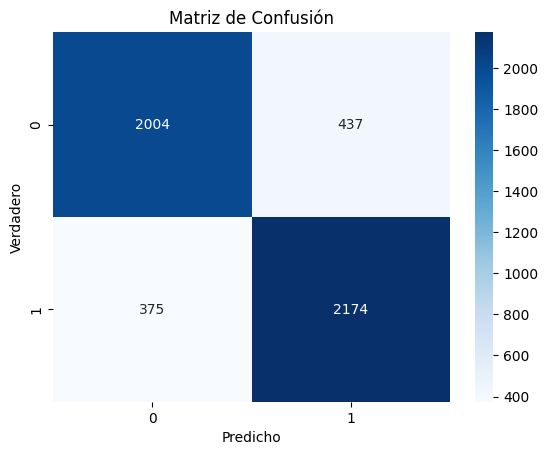

In [204]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.49).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [205]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2441
           1       0.83      0.85      0.84      2549

    accuracy                           0.84      4990
   macro avg       0.84      0.84      0.84      4990
weighted avg       0.84      0.84      0.84      4990



# InceptionV3 Unfreezed

In [207]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

In [208]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

Epoch 1/20
624/624 [==============================] - 71s 108ms/step - loss: 0.6318 - accuracy: 0.6519 - val_loss: 0.5653 - val_accuracy: 0.7116
Epoch 2/20
624/624 [==============================] - 67s 107ms/step - loss: 0.5597 - accuracy: 0.7170 - val_loss: 0.5526 - val_accuracy: 0.7190
Epoch 3/20
624/624 [==============================] - 67s 107ms/step - loss: 0.5073 - accuracy: 0.7501 - val_loss: 0.5319 - val_accuracy: 0.7415
Epoch 4/20
624/624 [==============================] - 67s 107ms/step - loss: 0.4469 - accuracy: 0.7903 - val_loss: 0.5365 - val_accuracy: 0.7375
Epoch 5/20
624/624 [==============================] - 67s 107ms/step - loss: 0.3772 - accuracy: 0.8297 - val_loss: 0.6070 - val_accuracy: 0.7299
Epoch 6/20
624/624 [==============================] - 67s 107ms/step - loss: 0.3003 - accuracy: 0.8694 - val_loss: 0.6961 - val_accuracy: 0.7387
Epoch 7/20
624/624 [==============================] - 67s 108ms/step - loss: 0.2275 - accuracy: 0.9058 - val_loss: 0.8587 - val_ac

1/1 [==============================] - 1s 732ms/step


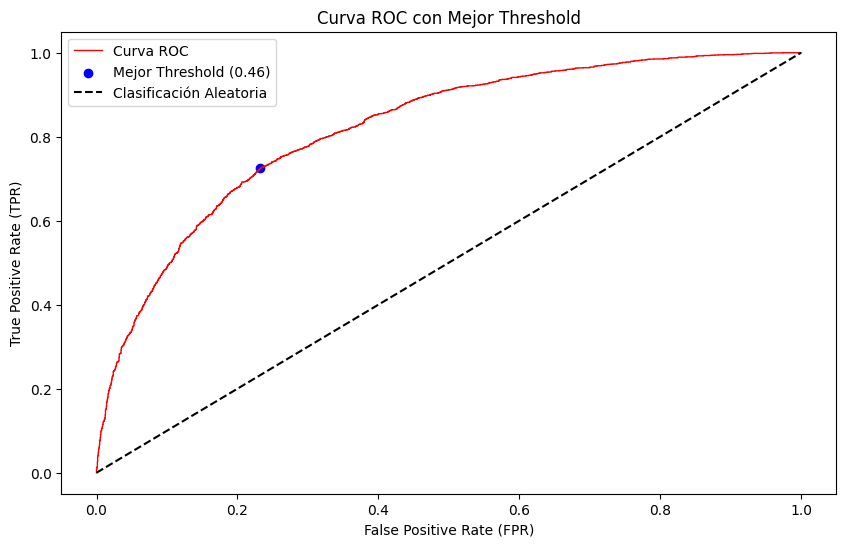

In [210]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

In [211]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 12s 78ms/step - loss: 0.5318 - accuracy: 0.7415
Accuracy: 0.7414829730987549


1/1 [==============================] - 0s 31ms/step


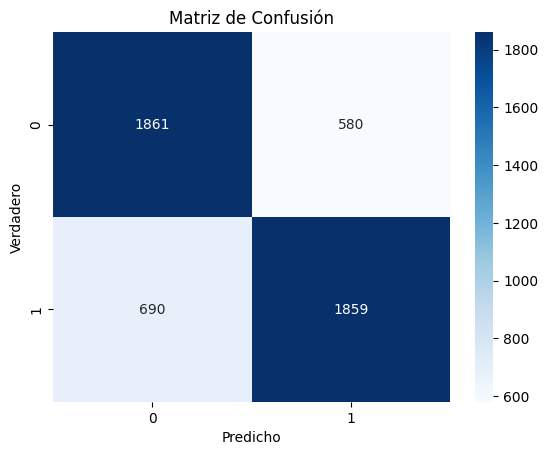

In [212]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.46).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [213]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      2441
           1       0.76      0.73      0.75      2549

    accuracy                           0.75      4990
   macro avg       0.75      0.75      0.75      4990
weighted avg       0.75      0.75      0.75      4990



# ResNet50 Unfreezed

In [220]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="binary_crossentropy")

94765736/94765736 [==============================] - 7s 0us/step


In [221]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

Epoch 1/20
624/624 [==============================] - 109s 170ms/step - loss: 0.0838 - accuracy: 0.9663 - val_loss: 0.0646 - val_accuracy: 0.9806
Epoch 2/20
624/624 [==============================] - 104s 166ms/step - loss: 0.0266 - accuracy: 0.9908 - val_loss: 0.0649 - val_accuracy: 0.9840
Epoch 3/20
624/624 [==============================] - 105s 168ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0830 - val_accuracy: 0.9808
Epoch 4/20
624/624 [==============================] - 105s 168ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0905 - val_accuracy: 0.9804
Epoch 5/20
624/624 [==============================] - 105s 168ms/step - loss: 0.0107 - accuracy: 0.9960 - val_loss: 0.0712 - val_accuracy: 0.9844
Epoch 6/20
624/624 [==============================] - 106s 169ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0992 - val_accuracy: 0.9810


1/1 [==============================] - 1s 602ms/step


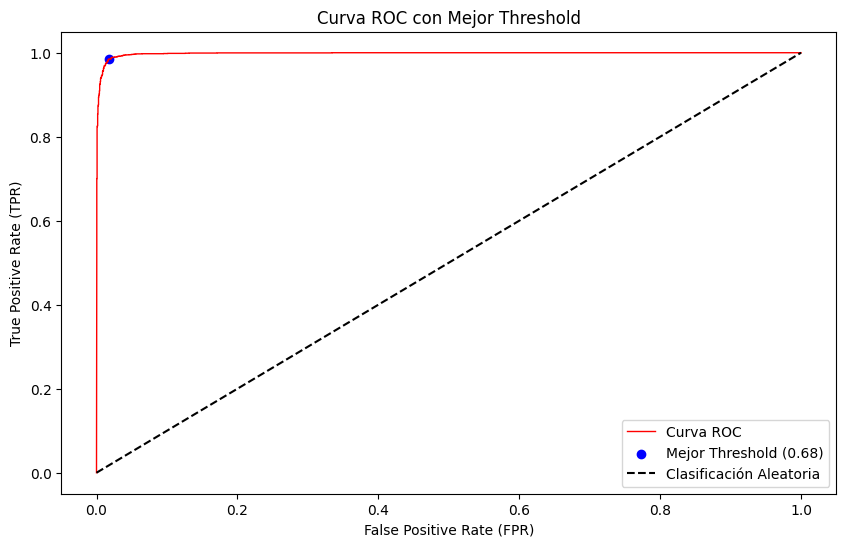

In [222]:
y_true_list = []
y_pred_probs_list = []  # Guardaremos las probabilidades en lugar de etiquetas binarias

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_probs_list.append(y_pred_probs)  # Guardamos las probabilidades

# Unir las listas en arrays
y_true = np.concatenate(y_true_list)
y_pred_probs = np.concatenate(y_pred_probs_list).flatten()  # Asegurar que sea un array 1D

FPR, TPR, cutoffs = roc_curve(y_true, y_pred_probs, pos_label=1)

optimal_idx = np.argmax(TPR - FPR)
best_threshold = cutoffs[optimal_idx]

plt.figure(figsize=(10, 6))

plt.plot(FPR, TPR, c='red', linewidth=1.0, label='Curva ROC')
plt.scatter(FPR[optimal_idx], TPR[optimal_idx], color='blue', label=f'Mejor Threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación Aleatoria')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC con Mejor Threshold')
plt.legend()
plt.show()

In [223]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

156/156 [==============================] - 17s 108ms/step - loss: 0.0643 - accuracy: 0.9806
Accuracy: 0.9805611371994019


1/1 [==============================] - 0s 31ms/step


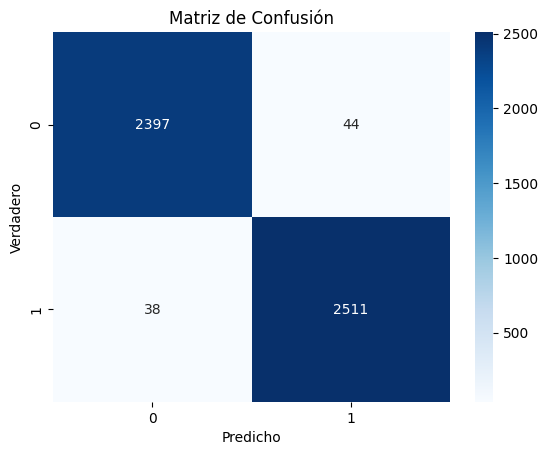

In [224]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = (y_pred_probs > 0.68).astype(int)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predicciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [225]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2441
           1       0.98      0.99      0.98      2549

    accuracy                           0.98      4990
   macro avg       0.98      0.98      0.98      4990
weighted avg       0.98      0.98      0.98      4990



In [231]:
# Cargar la imagen
img_path = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\Tarea 6\\perro.jpeg"  # Reemplaza con la ruta de tu imagen
img = image.load_img(img_path, target_size=(224, 224))  # Redimensionar

# Convertir la imagen a un array de numpy
img_array = image.img_to_array(img)

# Normalizar la imagen (MobileNetV2 usa valores entre 0 y 1)
img_array = img_array / 255.0

# Expandir dimensiones para que tenga forma (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Realizar la predicción
y_pred_probs = model.predict(img_array)

# Convertir a etiqueta binaria (0 o 1)
y_pred_label = (y_pred_probs > 0.57).astype(int)

# Mostrar el resultado
print(f"Probabilidad de ser clase 1: {y_pred_probs[0][0]:.4f}")
print(f"Clase predicha: {'Perro' if y_pred_label[0][0] == 1 else 'Gato'}")

1/1 [==============================] - 0s 20ms/step
Probabilidad de ser clase 1: 0.6797
Clase predicha: Perro


In [232]:
model.save("modelo_perros_gatos_ResNet50_Unfreeze.h5")  # Guardar el modelo

In [233]:
del model  # Elimina el modelo de la memoria RAM
tf.keras.backend.clear_session()  # Libera recursos de TensorFlow